In [1]:
pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 6.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.0/154.0 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 7.2 MB/s eta 0:00:00
  Using cached PyYAML-6.0-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (701 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.0/35.0 MB 6.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 262.1/262.1 kB 6.0 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 6.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 771.9/771.9 kB 7.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 6.6 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from transformers import AutoTokenizer
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import Compose, ColorJitter, ToTensor, Resize
from torchvision.models import ResNet50_Weights
from torch.utils.data import DataLoader
from tqdm import tqdm
from time import sleep
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
from datasets import load_dataset

dataset = load_dataset("frgfm/imagenette","160px")

Dataset imagenette downloaded and prepared to /home/hakim/.cache/huggingface/datasets/frgfm___imagenette/160px/1.0.0/38929285b8abcae5c1305418e9d8fea5dd6b189bbbd22caba5f5537c7fa0f01f. Subsequent calls will reuse this data.


100%|██████████| 2/2 [00:00<00:00, 992.97it/s]


In [5]:
jitter = Compose(
    [ ToTensor(),Resize((160,160))]
)

In [6]:
def transforms(examples):

    examples["pixel_values"] = [jitter(image.convert("RGB")) for image in examples["image"]]

    return examples

In [7]:
dataset = dataset.with_transform(transforms)

In [8]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set hyperparameters
num_epochs = 10
batch_size = 64
learning_rate = 0.001

In [9]:
def collate_fn(examples):

    images = []

    labels = []

    for example in examples:

        images.append((example["pixel_values"]))

        labels.append(example["label"])

        

    pixel_values = torch.stack(images)

    labels = torch.tensor(labels)

    return {"pixel_values": pixel_values, "label": labels}

train_dataloader = DataLoader(dataset["train"], collate_fn=collate_fn, batch_size=batch_size)
val_dataloader =  DataLoader(dataset["validation"], collate_fn=collate_fn, batch_size=batch_size)

In [10]:
model = torchvision.models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

In [11]:
model = model.to(device)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
tr = model.train()

In [13]:
train_accu = []
train_losses = []

def train(epoch,data):
    print('\nEpoch : %d'%epoch)
    correct = 0
    running_loss=0
    total=0
    for element in data:
        # Move input and label tensors to the device
        inputs = element["pixel_values"].to(device)
        labels = element["label"].to(device)

        # Zero out the optimizer
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss=running_loss/len(data)
    accu=100.*correct/total

    train_accu.append(accu)
    train_losses.append(train_loss)
    print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))


In [14]:
eval_losses=[]
eval_accu=[]

def val(data):
    correct = 0
    running_loss=0
    total=0
    with torch.no_grad():
      for element in data:
          # Move input and label tensors to the device
          inputs = element["pixel_values"].to(device)
          labels = element["label"].to(device)

        
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          running_loss += loss.item()

          _, predicted = outputs.max(1)
          total += labels.size(0)
          correct += predicted.eq(labels).sum().item()

    val_loss=running_loss/len(data)
    accu=100.*correct/total

    eval_accu.append(accu)
    eval_losses.append(val_loss)
    print('Val Loss: %.3f | Accuracy: %.3f'%(val_loss,accu))


In [40]:
epochs=10
for epoch in range(1,epochs+1):
  train(epoch,train_dataloader)
  val(val_dataloader)


Epoch : 1


/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train Loss: 4.034 | Accuracy: 35.833
Val Loss: 3.902 | Accuracy: 10.038

Epoch : 2
Train Loss: 1.663 | Accuracy: 60.196
Val Loss: 5.034 | Accuracy: 10.038

Epoch : 3
Train Loss: 1.406 | Accuracy: 62.731
Val Loss: 5.361 | Accuracy: 10.038

Epoch : 4
Train Loss: 1.420 | Accuracy: 59.742
Val Loss: 5.538 | Accuracy: 10.038

Epoch : 5
Train Loss: 1.167 | Accuracy: 66.374
Val Loss: 7.064 | Accuracy: 10.038

Epoch : 6
Train Loss: 1.161 | Accuracy: 67.737
Val Loss: 7.020 | Accuracy: 10.038

Epoch : 7
Train Loss: 1.072 | Accuracy: 64.569
Val Loss: 7.964 | Accuracy: 10.038

Epoch : 8
Train Loss: 1.068 | Accuracy: 67.916
Val Loss: 7.529 | Accuracy: 10.038

Epoch : 9
Train Loss: 1.091 | Accuracy: 65.899
Val Loss: 8.917 | Accuracy: 10.038

Epoch : 10
Train Loss: 1.130 | Accuracy: 66.881
Val Loss: 9.677 | Accuracy: 10.038


In [16]:
import matplotlib.pyplot as plt

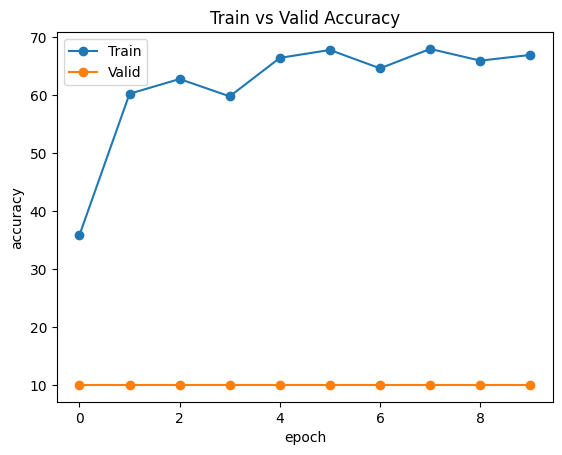

In [42]:
plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

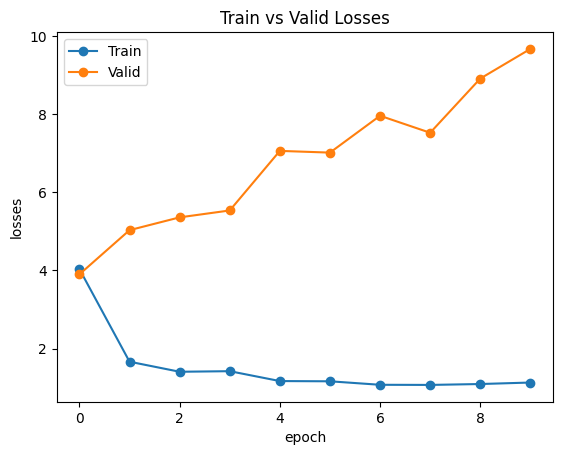

In [43]:
plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()

In [15]:
epochs=10
for epoch in range(1,epochs+1):
  train(epoch,train_dataloader)
  val(val_dataloader)


Epoch : 1


/home/hakim/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train Loss: 3.563 | Accuracy: 48.822
Val Loss: 3.338 | Accuracy: 10.038

Epoch : 2
Train Loss: 1.815 | Accuracy: 57.292
Val Loss: 4.007 | Accuracy: 10.038

Epoch : 3
Train Loss: 1.460 | Accuracy: 61.759
Val Loss: 4.876 | Accuracy: 10.038

Epoch : 4
Train Loss: 1.507 | Accuracy: 55.824
Val Loss: 4.745 | Accuracy: 10.038

Epoch : 5
Train Loss: 1.251 | Accuracy: 61.992
Val Loss: 5.491 | Accuracy: 10.038

Epoch : 6
Train Loss: 1.173 | Accuracy: 65.477
Val Loss: 5.813 | Accuracy: 10.038

Epoch : 7
Train Loss: 1.207 | Accuracy: 65.097
Val Loss: 6.291 | Accuracy: 10.038

Epoch : 8
Train Loss: 1.137 | Accuracy: 66.712
Val Loss: 7.113 | Accuracy: 10.038

Epoch : 9
Train Loss: 1.209 | Accuracy: 71.159
Val Loss: 6.961 | Accuracy: 10.038

Epoch : 10
Train Loss: 1.104 | Accuracy: 65.033
Val Loss: 6.427 | Accuracy: 10.038


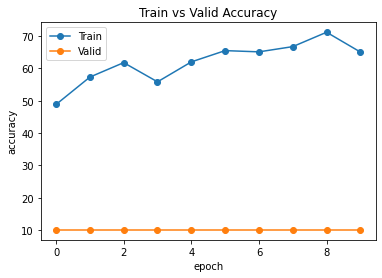

In [17]:
plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

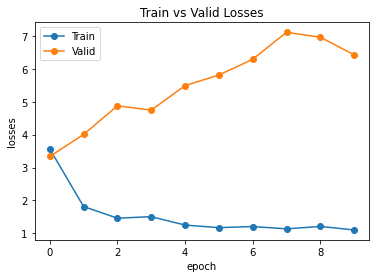

In [18]:
plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()

In [ ]:
from torchvision.io import read_image

img = read_image("test/assets/encode_jpeg/grace_hopper_517x606.jpg")

# Step 1: Initialize model with the best available weights
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
model.eval()

# Step 2: Initialize the inference transforms
preprocess = weights.transforms()

# Step 3: Apply inference preprocessing transforms
batch = preprocess(img).unsqueeze(0)

# Step 4: Use the model and print the predicted category
prediction = model(batch).squeeze(0).softmax(0)
class_id = prediction.argmax().item()
score = prediction[class_id].item()
category_name = weights.meta["categories"][class_id]
print(f"{category_name}: {100 * score:.1f}%")

In [64]:
from PIL import Image

model.eval()
image = Image.open('test.jpg')
  
# Define a transform to convert PIL 
# image to a Torch tensor
transform = Compose([
    ToTensor()
])
  
# transform = transforms.PILToTensor()
# Convert the PIL image to Torch tensor

img_tensor = transform(image)

inputs = img_tensor.to(device)

with torch.no_grad():
    outputs = model(inputs.unsqueeze(0))
    _, predicted = torch.max(outputs.data, 1)
    
    print(predicted)

tensor([5], device='cuda:0')


In [65]:
dataset["train"].features["label"].names[predicted]

'French horn'